In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump, load
try:
    import xgboost as xgb, shap
except ImportError:
    %pip install xgboost shap
    import xgboost as xgb,shap
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Read csv

In [54]:
data = pd.read_csv('./datasets/simulated_loan_data.csv')

First 5 records

In [55]:
data.head()

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,utility_payment_timeliness,has_previous_loan,gender,region,default
0,56,97050,4775,7,77,2296,on-time,0,F,Nairobi,0
1,46,23323,3421,30,129,9995,on-time,0,M,Nairobi,0
2,32,23019,14025,60,9,1075,early,0,F,Nairobi,1
3,25,80426,10280,14,58,6221,on-time,0,M,Nyeri,0
4,38,45863,37951,7,90,1128,on-time,1,F,Eldoret,1


Last 5 records

In [56]:
data.tail()

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,utility_payment_timeliness,has_previous_loan,gender,region,default
4995,32,9512,31654,60,131,415,on-time,1,M,Nyeri,1
4996,36,27666,10669,14,46,4089,on-time,1,F,Mombasa,0
4997,52,21630,22784,14,121,9393,on-time,0,F,Eldoret,1
4998,34,79519,30672,14,15,630,late,1,F,Kisumu,1
4999,52,5636,2082,14,30,7984,early,1,M,Eldoret,0


Info on dataset

In [57]:
data.shape

(5000, 11)

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   age                         5000 non-null   int64 
 1   monthly_income              5000 non-null   int64 
 2   loan_amount                 5000 non-null   int64 
 3   repayment_period            5000 non-null   int64 
 4   transaction_volume_mtd      5000 non-null   int64 
 5   avg_mpesa_balance           5000 non-null   int64 
 6   utility_payment_timeliness  5000 non-null   object
 7   has_previous_loan           5000 non-null   int64 
 8   gender                      5000 non-null   object
 9   region                      5000 non-null   object
 10  default                     5000 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 429.8+ KB


Statistical description of the dataset

In [59]:
data.describe(include='all')

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,utility_payment_timeliness,has_previous_loan,gender,region,default
count,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.00000,5000,5000.000000,5000,5000,5000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,2,5,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,on-time,NaN,F,Kisumu,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3022,NaN,2547,1039,NaN
mean,38.662200,52086.182800,25077.96620,27.640000,77.65400,5032.48660,NaN,0.611200,NaN,NaN,0.658000
std,12.028492,27759.178866,14084.57569,20.278349,41.83726,2844.14216,NaN,0.487527,NaN,NaN,0.474427
min,18.000000,5002.000000,1005.00000,7.000000,5.00000,100.00000,NaN,0.000000,NaN,NaN,0.000000
25%,28.000000,27819.000000,12802.75000,14.000000,42.00000,2579.75000,NaN,0.000000,NaN,NaN,0.000000
50%,39.000000,51611.000000,24765.00000,14.000000,77.50000,5049.50000,NaN,1.000000,NaN,NaN,1.000000
75%,49.000000,76562.000000,37304.75000,30.000000,114.00000,7498.75000,NaN,1.000000,NaN,NaN,1.000000


Missing values

In [60]:
data.isnull().sum()

age                           0
monthly_income                0
loan_amount                   0
repayment_period              0
transaction_volume_mtd        0
avg_mpesa_balance             0
utility_payment_timeliness    0
has_previous_loan             0
gender                        0
region                        0
default                       0
dtype: int64

Duplicates

In [61]:
data.duplicated().sum()

0

Check pairwise correlations

In [62]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
data[numeric_cols].corr()

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,has_previous_loan,default
age,1.000000,-0.010136,0.008850,0.017638,0.013811,0.019776,0.007208,0.012597
monthly_income,-0.010136,1.000000,0.005408,-0.013696,0.023187,0.013502,0.016618,-0.402600
loan_amount,0.008850,0.005408,1.000000,-0.007050,0.014932,0.017751,0.003221,0.405682
repayment_period,0.017638,-0.013696,-0.007050,1.000000,-0.041987,-0.015115,-0.019644,0.012463
transaction_volume_mtd,0.013811,0.023187,0.014932,-0.041987,1.000000,-0.011458,-0.006352,0.001697
avg_mpesa_balance,0.019776,0.013502,0.017751,-0.015115,-0.011458,1.000000,0.018796,0.004515
has_previous_loan,0.007208,0.016618,0.003221,-0.019644,-0.006352,0.018796,1.000000,0.121213
default,0.012597,-0.402600,0.405682,0.012463,0.001697,0.004515,0.121213,1.000000


Distribution of Numerical features

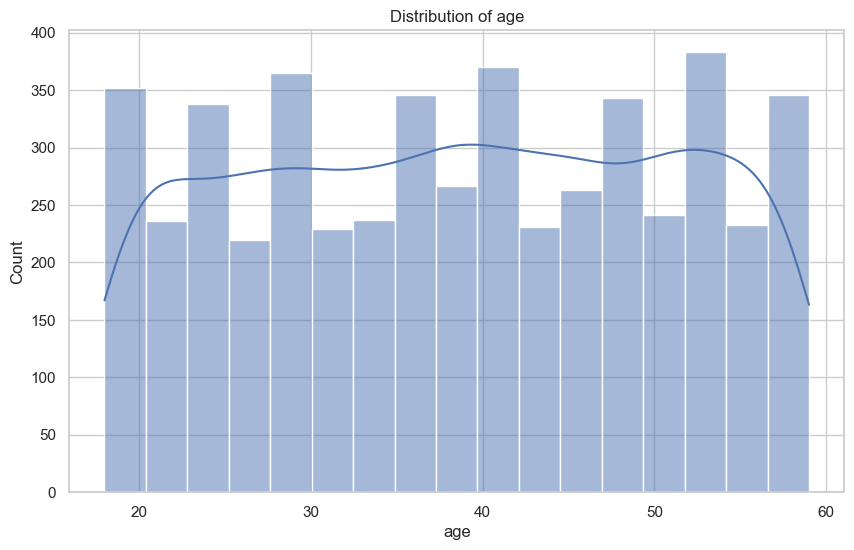

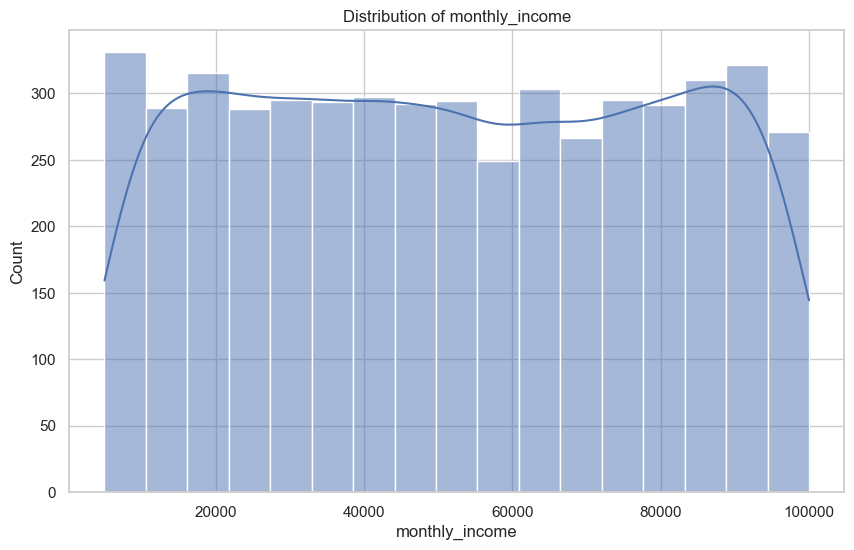

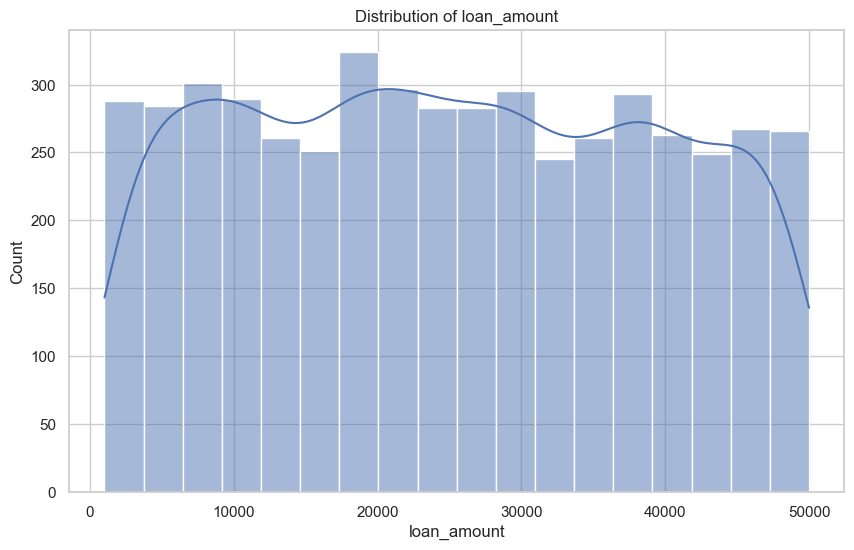

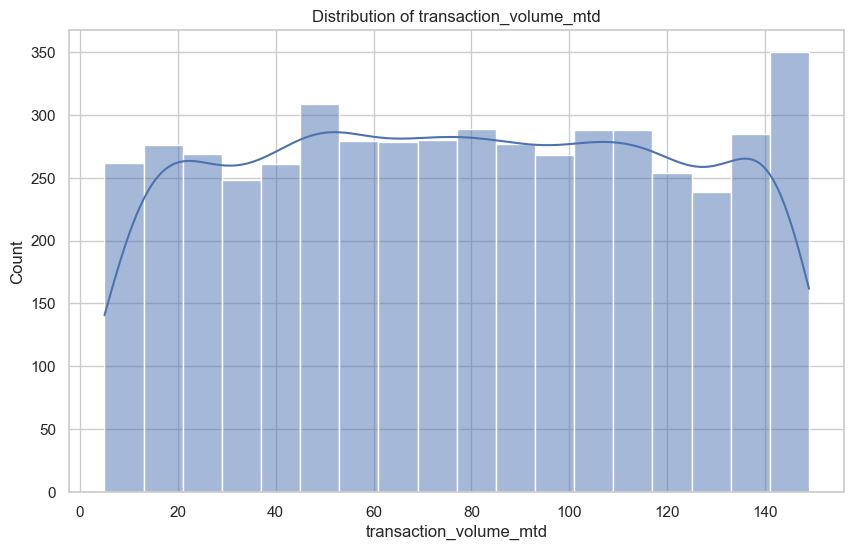

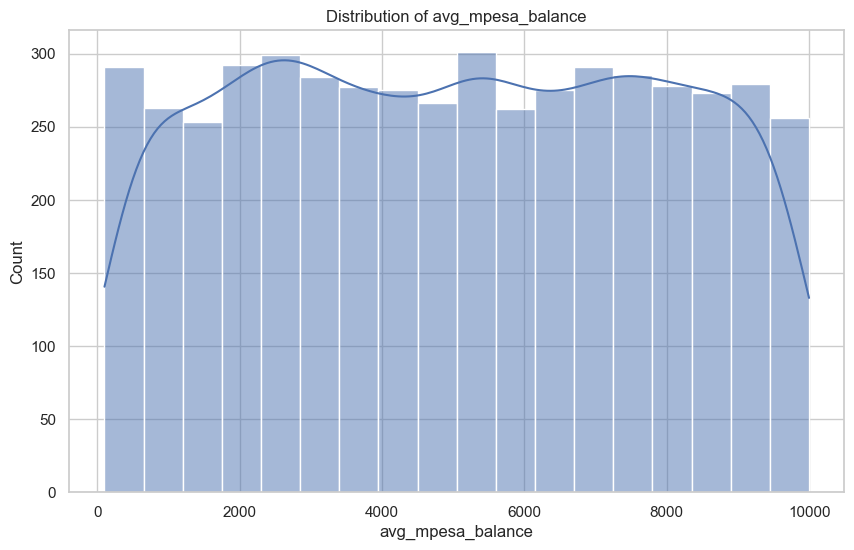

In [63]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
sns.set(style="whitegrid")
for col in numeric_cols:
    if col not in ['has_previous_loan', 'repayment_period', 'default']:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[col], kde=True)
        plt.title(f'Distribution of {col}')
        plt.show()

Check for outliers for numeric columns

<Axes: >

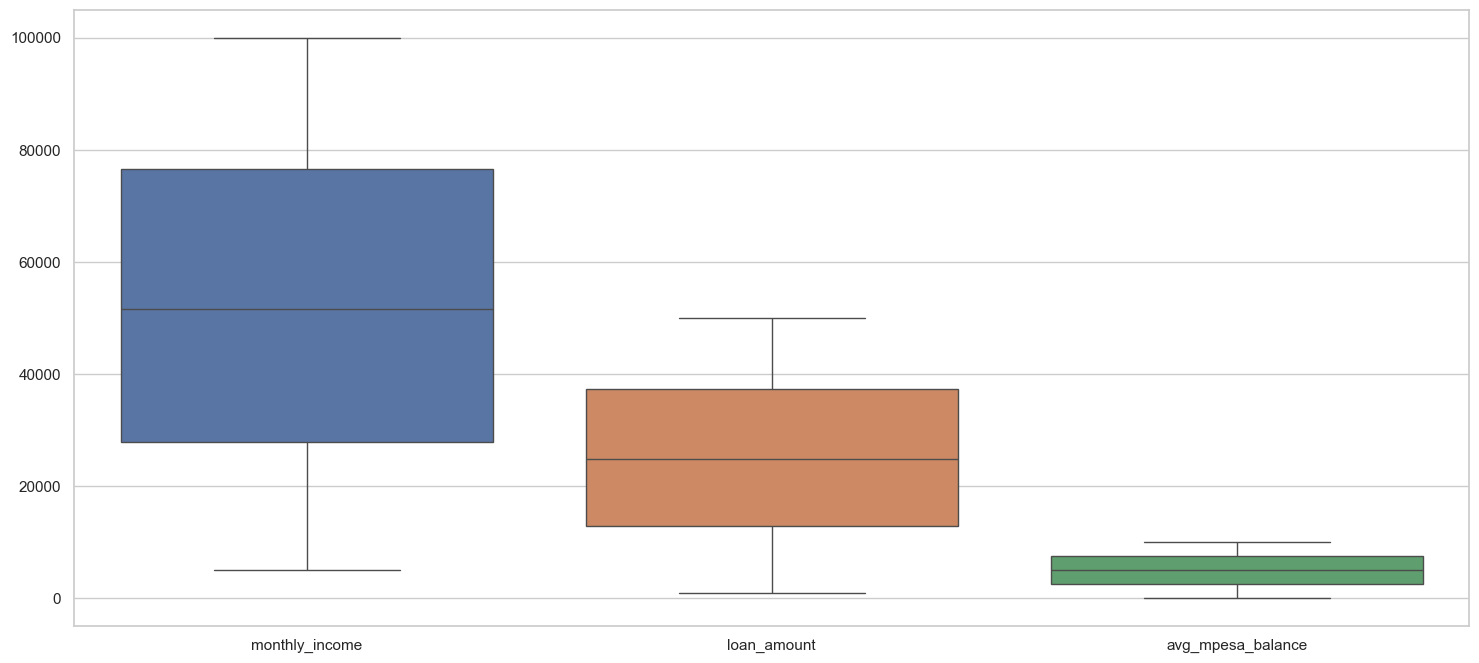

In [64]:
cols = ['monthly_income', 'loan_amount', 'avg_mpesa_balance']
plt.figure(figsize=(18, 8))
sns.boxplot(data[cols])

Average loan amount

In [65]:
data['loan_amount'].mean()

25077.9662

In [66]:
data.groupby('gender')['loan_amount'].mean()

gender
F    25319.471535
M    24827.206278
Name: loan_amount, dtype: float64

Income level vs loan amounts

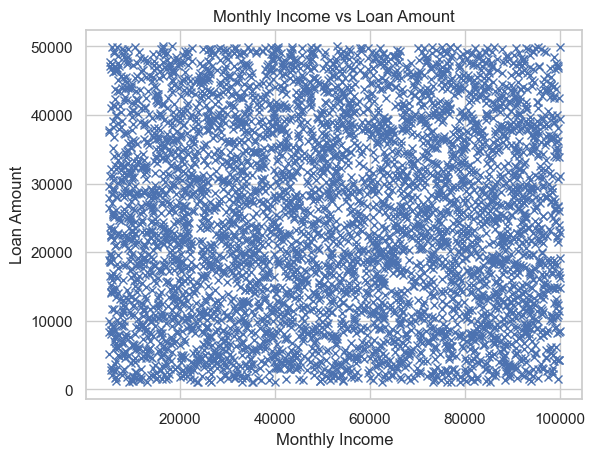

In [67]:
plt.plot(data['monthly_income'], data['loan_amount'], 'x')
plt.title('Monthly Income vs Loan Amount')
plt.xlabel('Monthly Income')
plt.ylabel('Loan Amount')
plt.show()

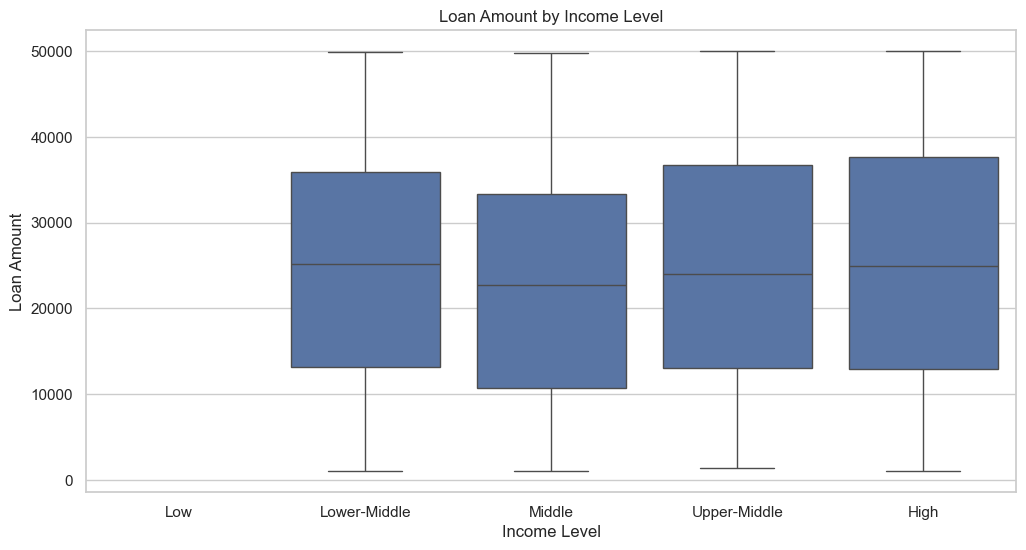

In [68]:
data['income_level'] = pd.cut(data['monthly_income'], bins=[0, 5000, 10000, 15000, 20000, np.inf], labels=['Low', 'Lower-Middle', 'Middle', 'Upper-Middle', 'High'])
plt.figure(figsize=(12, 6))
sns.boxplot(x='income_level', y='loan_amount', data=data)
plt.title('Loan Amount by Income Level')
plt.xlabel('Income Level')
plt.ylabel('Loan Amount')
plt.show()

Age groups and default

C:\Users\USER\AppData\Local\Temp\ipykernel_22356\1446376712.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby('age_group')['default'].value_counts(normalize=True).unstack().fillna(0)


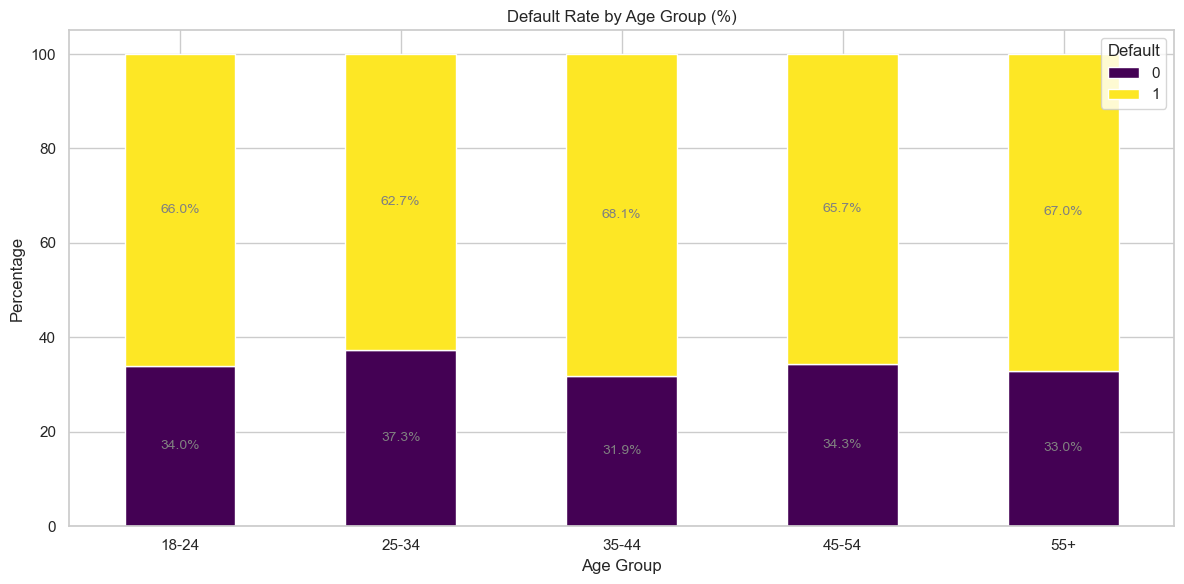

In [69]:
data['age_group'] = pd.cut(data['age'], bins=[18, 25, 35, 45, 55, np.inf], labels=['18-24', '25-34', '35-44', '45-54', '55+'])
grouped = data.groupby('age_group')['default'].value_counts(normalize=True).unstack().fillna(0)

percentages = grouped * 100

ax = percentages.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='viridis')
plt.title('Default Rate by Age Group (%)')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='Default', loc='upper right')

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, p.get_y() + height / 2),
                    ha='center', va='center', fontsize=10, color='grey')

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Grouping borrowers based on payment behavior

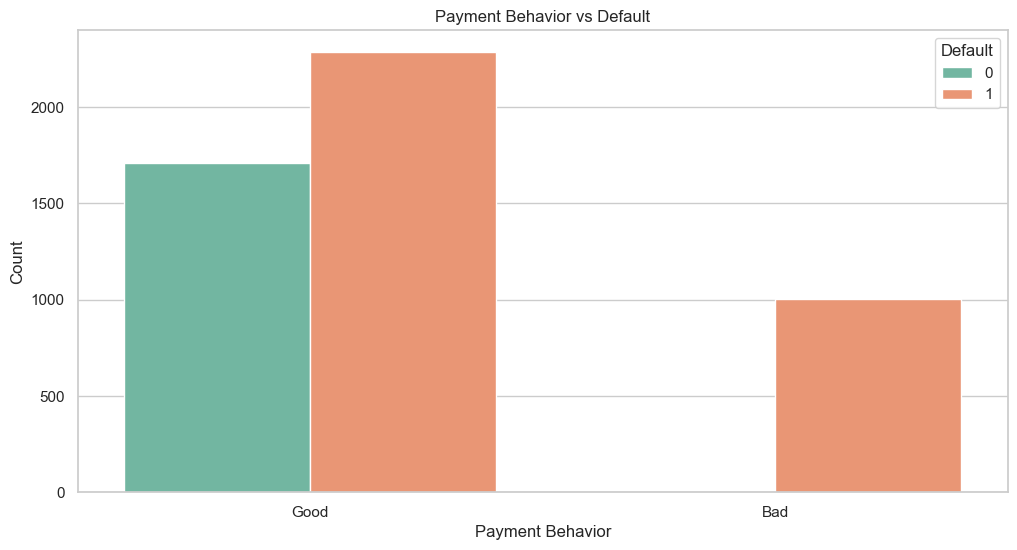

In [70]:
data['payment_behavior'] = data['utility_payment_timeliness'].apply(lambda x: 'Good' if x == 'early' or x == 'on-time' else 'Bad')
plt.figure(figsize=(12, 6))
sns.countplot(x='payment_behavior', hue='default', data=data, palette='Set2')
plt.title('Payment Behavior vs Default')
plt.xlabel('Payment Behavior')
plt.ylabel('Count')
plt.legend(title='Default')
plt.show()

In [71]:
data['income_level'].unique()

['High', 'Upper-Middle', 'Middle', 'Lower-Middle']
Categories (5, object): ['Low' < 'Lower-Middle' < 'Middle' < 'Upper-Middle' < 'High']

Feature Engineering

In [72]:
data['loan_to_income_ratio'] = data['loan_amount'] / data['monthly_income']
data['payment_discipline_score'] = data['utility_payment_timeliness'].map({'early': 1, 'on-time': 0.5, 'late': 0})

income_level_map = {
    'Low': 1.0,
    'Lower-Middle': 0.8,
    'Middle': 0.6,
    'Upper-Middle': 0.4,
    'High': 0.2
}
data['income_adjusted_loan_ratio'] = data['loan_to_income_ratio'] / data['income_level'].map(income_level_map).astype(float)

behavior_features = [
    'payment_behavior',
    'utility_payment_timeliness',
    'payment_discipline_score'
]

data['reliable_borrower'] = ((data['has_previous_loan'] == 1) & 
                           (data['payment_behavior'] == 'Good')).astype(int)

data.head()

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,utility_payment_timeliness,has_previous_loan,gender,region,default,income_level,age_group,payment_behavior,loan_to_income_ratio,payment_discipline_score,income_adjusted_loan_ratio,reliable_borrower
0,56,97050,4775,7,77,2296,on-time,0,F,Nairobi,0,High,55+,Good,0.049201,0.5,0.246007,0
1,46,23323,3421,30,129,9995,on-time,0,M,Nairobi,0,High,45-54,Good,0.146679,0.5,0.733396,0
2,32,23019,14025,60,9,1075,early,0,F,Nairobi,1,High,25-34,Good,0.609279,1.0,3.046396,0
3,25,80426,10280,14,58,6221,on-time,0,M,Nyeri,0,High,18-24,Good,0.127819,0.5,0.639097,0
4,38,45863,37951,7,90,1128,on-time,1,F,Eldoret,1,High,35-44,Good,0.827486,0.5,4.137431,1


Convert categorical data into numerical

In [73]:
le = LabelEncoder()
oh = OneHotEncoder()
data['gender'] = le.fit_transform(data['gender'])
data['utility_payment_timeliness'] = le.fit_transform(data['utility_payment_timeliness'])
data['region'] = oh.fit_transform(data['region'].values.reshape(-1, 1)).toarray()
data['income_level'] = le.fit_transform(data['income_level'])
data['age_group'] = oh.fit_transform(data['age_group'].values.reshape(-1, 1)).toarray()
data['payment_behavior'] = le.fit_transform(data['payment_behavior'])

In [74]:
data.head()

,age,monthly_income,loan_amount,repayment_period,transaction_volume_mtd,avg_mpesa_balance,utility_payment_timeliness,has_previous_loan,gender,region,default,income_level,age_group,payment_behavior,loan_to_income_ratio,payment_discipline_score,income_adjusted_loan_ratio,reliable_borrower
0,56,97050,4775,7,77,2296,2,0,0,0.0,0,0,0.0,1,0.049201,0.5,0.246007,0
1,46,23323,3421,30,129,9995,2,0,1,0.0,0,0,0.0,1,0.146679,0.5,0.733396,0
2,32,23019,14025,60,9,1075,0,0,0,0.0,1,0,0.0,1,0.609279,1.0,3.046396,0
3,25,80426,10280,14,58,6221,2,0,1,0.0,0,0,1.0,1,0.127819,0.5,0.639097,0
4,38,45863,37951,7,90,1128,2,1,0,1.0,1,0,0.0,1,0.827486,0.5,4.137431,1


Identify features and target

In [75]:
X = data.drop(columns=['default', 'transaction_volume_mtd', 'repayment_period', 'age', 'avg_mpesa_balance', 'loan_amount', 'region', 'income_level', 'age_group', 'gender'])
y = data['default']

Effect of dimensionality reduction (e.g. PCA or t-SNE)

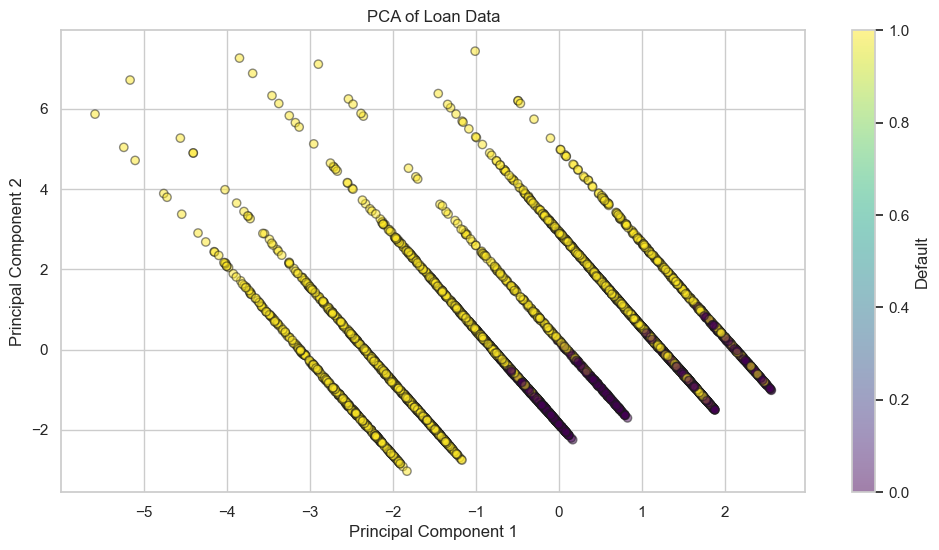

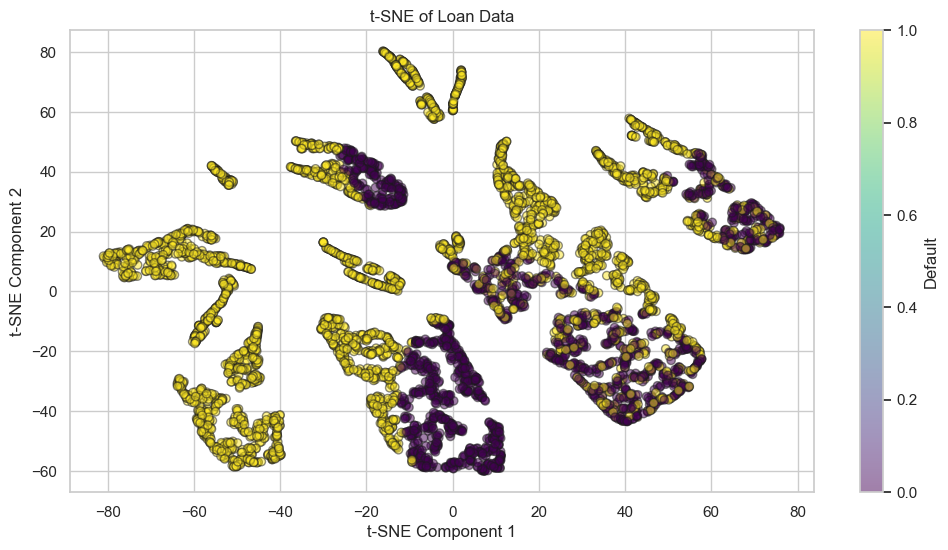

In [76]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title('PCA of Loan Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Default')
plt.show()

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(12, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', alpha=0.5, edgecolor='k')
plt.title('t-SNE of Loan Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Default')
plt.show()

Normalize features

In [77]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_cols:
    if col in X:
        X[col] = scaler.fit_transform(X[[col]])

Split data into train and test sets

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

Handling Imbalance, SMOTE

In [79]:
# Applying SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
X_train = X_train_res
y_train = y_train_res

XGBoost Classifier

In [80]:
# RandomizedSearchCV for XGBoost Classifier
param_dist_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

classifier_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search_xgb = RandomizedSearchCV(classifier_xgb, param_distributions=param_dist_xgb, n_iter=50, scoring='f1', cv=3, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:11:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'reg_alpha': [0, 0.1, 0.5],
                                        'reg_lambda': [0, 0.1, 0.5],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [81]:
# Train XGBoost Model
classifier_xgb = xgb.XGBClassifier(**random_search_xgb.best_params_, use_label_encoder=False, eval_metric='logloss', random_state=42)
classifier_xgb.fit(X_train, y_train)

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:12:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [82]:
# Make predictions on the test set
y_pred_xgb = classifier_xgb.predict(X_test)

In [83]:
# Model performance
print("Accuracy for XGBoost:", accuracy_score(y_test, y_pred_xgb))
print("Confusion Matrix for XGBoost:\n", confusion_matrix(y_test, y_pred_xgb))
print("Classification Report for XGBoost:\n", classification_report(y_test, y_pred_xgb))

Accuracy for XGBoost: 0.9226666666666666
Confusion Matrix for XGBoost:
 [[254   3]
 [ 55 438]]
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90       257
           1       0.99      0.89      0.94       493

    accuracy                           0.92       750
   macro avg       0.91      0.94      0.92       750
weighted avg       0.93      0.92      0.92       750



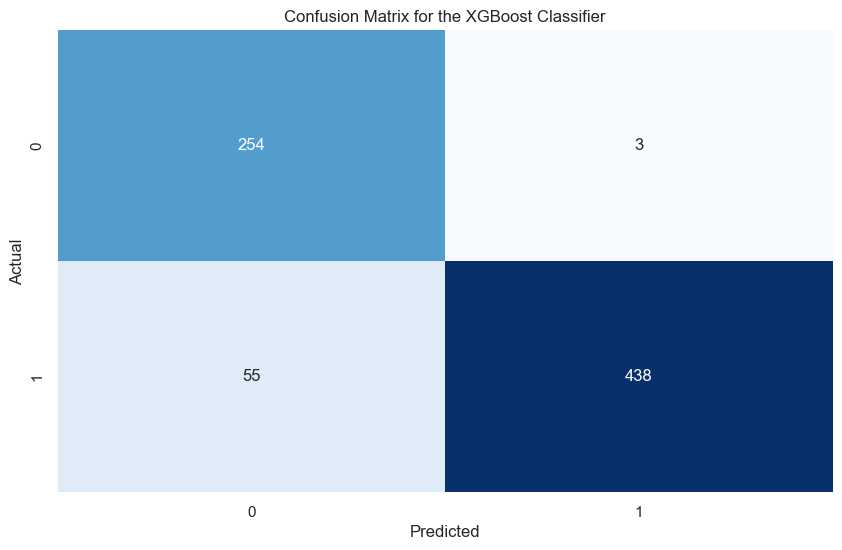

In [84]:
# Plot confusion matrix for XGBoost
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for the XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 1200x600 with 0 Axes>

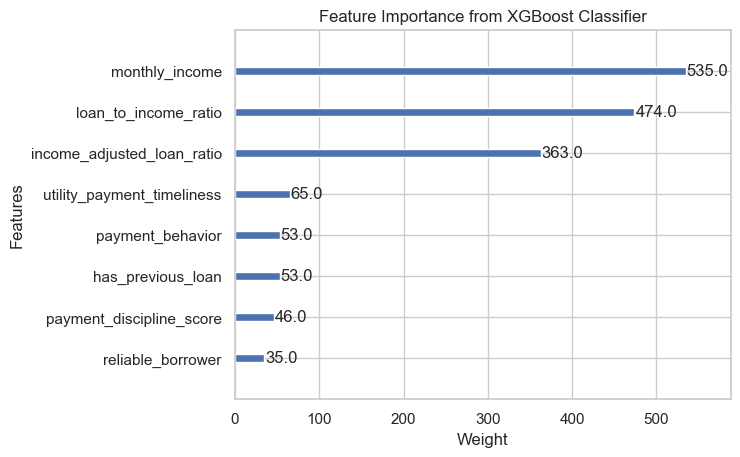

In [85]:
# Feature Importance for XGBoost
plt.figure(figsize=(12, 6))
xgb.plot_importance(classifier_xgb, importance_type='weight', max_num_features=10)
plt.title('Feature Importance from XGBoost Classifier')
plt.xlabel('Weight')
plt.ylabel('Features')
plt.show()

SHAP model explainability

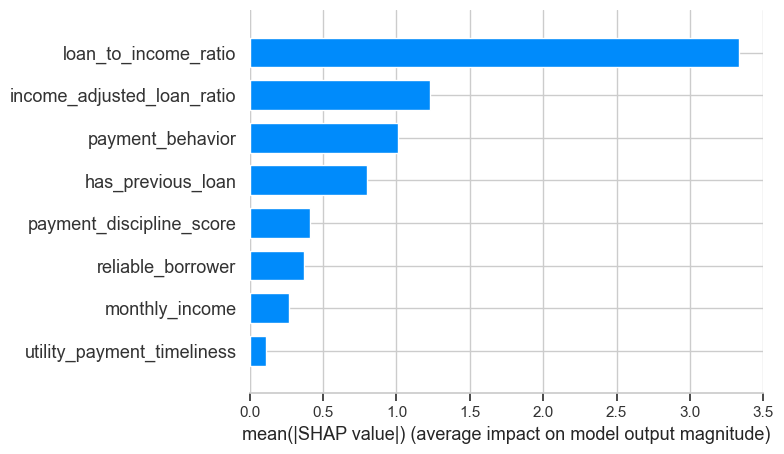

In [86]:
# Shap model explainability
explainer = shap.TreeExplainer(classifier_xgb)
shap_values = explainer.shap_values(X_test)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")

Saving the model

In [87]:
# Using joblib to save the model
dump(classifier_xgb, 'xgboost_classifier.joblib')
print("Model saved as 'xgboost_classifier.joblib'")

# Load the model
# classifier_xgb = load('xgboost_classifier.joblib')

Model saved as 'xgboost_classifier.joblib'
